In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
import pickle
import time
import numbers

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### In this tutorial: 

We will show how to train the Foliar/Ground cover estimator from scratch. We will define the necessary layers and load the required data. Then we define the learning rate decay and compile the model and train it. Through a 10-folds cross validation loop, we predict the Foliar/Ground cover of the data points. Finally we run the RHEM Emulator for them to see how much of the RHEM outputs can be retrieved by the estimated covers.

### Define the Partial Convolutional layer:

We used <a href="https://arxiv.org/abs/1804.07723">Partial Convolutional</a> layers in the neural network. This layer is not one of the pre-defined tensorflow layers so we need to make it ourselves. run the cell below to define the custom layer:

In [303]:
class PConv2D(tf.keras.layers.Conv2D):
    def __init__(self, mask_val=None, clip_threshold=None, output_mask_val=-999., prelu = False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask_val = mask_val
        self.clip_threshold = clip_threshold
        self.output_mask_val = output_mask_val
        self.prelu = prelu

    def build(self, input_shape):
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[channel_axis]
        
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.prelu = tf.keras.layers.PReLU()
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # threshold parameter for making the output mask
        
        if self.clip_threshold is None:
            self.thresh = self.add_weight(initializer= tf.random_normal_initializer(), trainable=True, name='img_thresh')

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, input0, mask0=None):
        images = input0
        
        if self.mask_val is None:
            if mask0 is None:
                raise Exception('Either of mask or mask_val must be specified')
                
            else:
                masks = mask0
        else:
            if mask0 is not None:
                raise Exception('mask and mask_val cannot be specified at the same time')
            
            else:
                masks = K.not_equal(images, self.mask_val)
                masks = K.cast(masks, dtype=K.floatx())

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )
        
        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = (self.window_size *  self.input_dim)/ (mask_output + 1e-8)

        if self.clip_threshold is not None: # 1- hard mask by a user defined threshold
            mask_output1 = tf.keras.activations.relu(tf.add(tf.subtract(mask_output, self.window_size *  self.input_dim * self.clip_threshold), 1), threshold=1)

        else: # 2- hard mask by a learnt threshold
            mask_output1 = tf.keras.activations.relu(tf.add(tf.subtract(mask_output, self.window_size *  self.input_dim * tf.keras.activations.sigmoid(self.thresh)), 1), threshold=1)
        
        mask_output1 = K.clip(mask_output1, 0, 1) 

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
            img_output = img_output * mask_output1 ### not adding bias to zeros
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
        
        else:
            if self.prelu:
                img_output = self.prelu(img_output)

        mask_999 = tf.math.subtract(1., mask_output1)
        mask_999 = tf.math.multiply(self.output_mask_val, mask_999)
        
        img_output = img_output * mask_output1
        img_output = img_output + mask_999
        
        return img_output

### Load the required dataset:

The Foliar/Ground cover estimator expects 3 sets of inputs:


1- Five years of Landsat time series in shape (20,3,3,22): 20 time steps (4 seasons of 5 years before the selected date. For instance, if we are going to estimate the Foliar and Ground covers of a location for Summer 2020, the seasonal time series starts from Fall 2015 and ends on Summer 2020), 3 by 3 pixels and, 22 channels including Landsat bands and some indices like NDVI, EVI, etc. Run the cell below to load the Landsat data. It loads a numpy array of shape (66643,20,3,3,22) which is the time series of Landsat data for the whole dataset concatenated. It also prints the metadata of the array to make sure everything is loaded as expected.

In [407]:
landsat = np.load('Files/Data/NRI_BLM_Landsat.npz',allow_pickle=True, mmap_mode='r')['arr_0'].astype('float32')

print('There are',
     landsat.shape[0],
     'data samples'
     )

print('Each sample has a time series of length',
     landsat.shape[1],
     'and shape',
      landsat.shape[2],
      'by',
      landsat.shape[3],
      'with',
      landsat.shape[4],
      'Landsat attributes for the first input channel of the model'
     )

There are 66643 data samples
Each sample has a time series of length 20 and shape 3 by 3 with 22 Landsat attributes for the first input channel of the model


2- Five years of PRISM time series in shape (20,2): 20 seasonal time steps and two climatic features of precipitation and temperature. Run the cell below to load the PRISM data. It loads a numpy array of shape (66643,20,2) which is the time series of PRISM data for the whole dataset concatenated. It also prints the metadata of the array to make sure everything is loaded as expected.


In [406]:
prism = np.load('Files/Data/NRI_BLM_PRISM.npz',allow_pickle=True, mmap_mode='r')['arr_0'].astype('float32')

print('Each sample has a time series of length',
     prism.shape[1],
      'with',
      prism.shape[2],
      'PRISM attributes for the second input channel of the model'
     )

Each sample has a time series of length 20 with 2 PRISM attributes for the second input channel of the model


3- Latitude, Longitude and the information about the soil texture: Here we load a csv file that contains these data. The csv file must have the following columns (Please note that due to the confidentiality rules of the NRI data, we did not include the latitude and longitude information in this example. So the final accuracy of the Foliar/Ground cover estimator that we make here might be less than what we got in our manuscript): 

- latitude (if available)
- longitude (if available)
- soil texture: 
    - sand
    - loamy sand
    - sandy loam
    - loam
    - silt loam
    - silt
    - sandy clay loam
    - clay loam
    - silty clay loam
    - sandy clay
    - silty clay
    - clay
    
It also must have a column named "index1" which shows the index of the first axis of the loaded Landsat and PRISM arrays. For instance, if the "index1" of a row is 23 we can find its corresponding Landsat data using the following slicing command:

landsat[23,...]

or we can find its corresponding PRISM data using the following slicing command:

prism[23,...]

Finally, the csv file must have the Foliar/Ground cover columns as follows:

- Litter
- BiologicalCrusts
- Basal
- Rock
- Forbs
- BunchGrass
- Shrubs
- SodGrass

So far we have all the columns that the estimator expects to get for training. We also need the following columns to run the RHEM emulator by the estimated Ground/Foliar covers (See Use_Emulator.ipynb notebook for more information):

- Slope percentage (between 0 and 100)
- Slope Shape (Uniform(or Linear), Concave, Convex)
- CLIGEN station

Run the cell below to load the csv table with all of the above information:

In [5]:
rsDataset = pd.read_csv('Files/Data/RSdataset.csv')

#### uncomment the line below for shuffling the dataset
#rsDataset = rsDataset.sample(frac=1).reset_index(drop=True)

rsDataset

,Litter,BiologicalCrusts,Basal,Rock,Forbs,BunchGrass,Shrubs,SodGrass,soil,slope,slopeShape,source,ID,index1
0,97.029703,0.000000,0.000000,0.000000,83.168317,12.871287,0.000000,0.000000,Clay Loam,24.000000,Convex,NRI,ca045915,0
1,26.732673,0.000000,6.930693,64.356436,0.000000,6.930693,28.712871,0.990099,Sandy Loam,8.511858,Uniform,LMF,nv267908,1
2,44.554455,0.000000,0.000000,0.000000,71.287129,10.891089,2.970297,0.990099,Sandy Loam,1.000000,Uniform,NRI,ks141704,2
3,62.000000,0.000000,2.666667,0.000000,30.000000,4.666667,39.333333,0.000000,Loam,5.053417,Uniform,AIM,ut420086,3
4,34.653465,0.000000,3.960396,18.811881,8.910891,6.930693,4.950495,12.871287,Loam,6.000000,Convex,NRI,mt245754,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66638,67.326733,0.990099,13.861386,0.000000,15.841584,28.712871,44.554455,0.000000,Loam,3.750074,Concave,LMF,mt241102,66638
66639,54.666667,0.000000,1.333333,25.333333,2.000000,6.000000,2.000000,41.333333,Loam,13.157881,Concave,AIM,co056266,66639
66640,40.594059,0.000000,0.990099,49.504950,0.000000,2.970297,31.683168,0.000000,Loam,20.000000,Convex,NRI,tx411398,66640
66641,70.297030,0.000000,5.940594,0.000000,8.910891,52.475248,8.910891,0.000000,Sandy Loam,0.300000,Uniform,NRI,co054770,66641


Each one of the softmax output layers of the Foliar/Ground cover estimator results in 5 categories. For the Ground cover, they are Litter, BiologicalCrusts, Basal, Rock and an extra one which is (100% - sum of the four categories). The same thing is applied for the Foliar cover output: Forbs, BunchGrass, Shrubs, SodGrass and an extra one which is (100% - sum of the four categories). Run the cell below to create these two extra columns named "diffGround" and "diffFoliar":

In [6]:
rsDataset['diffGround'] = 100 - rsDataset['Litter'] - rsDataset['BiologicalCrusts'] - rsDataset['Basal'] - rsDataset['Rock']
rsDataset['diffFoliar'] = 100 - rsDataset['Forbs'] - rsDataset['BunchGrass'] - rsDataset['Shrubs'] - rsDataset['SodGrass']

Now we get the soil properties and climate information of each row using two guide tables:

In [386]:
# loading the climate guide table and merge the information
cligenTab = pd.read_csv('Files/Parameter_Files/cligen.csv')
rsDataset = rsDataset.merge(cligenTab, left_on='ID', right_on='ID', how='left')

# loading the soil guide table and merge the information
soil = pd.read_csv('Files/Parameter_Files/Soil_Hydraulic_Properties.csv')
rsDataset['soil'] = rsDataset['soil'].str.lower() # lowercasing the soil names in the Dataset table to match the guid
rsDataset = rsDataset.merge(soil, left_on='soil', right_on='Soil_Texture_Class', how='left')
rsDataset

,Litter,BiologicalCrusts,Basal,Rock,Forbs,BunchGrass,Shrubs,SodGrass,soil,slope,...,Soil_Texture_Class,G,DIST,POR,SMAX,FRAC1,FRAC2,FRAC3,FRAC4,FRAC5
0,97.029703,0.000000,0.000000,0.000000,83.168317,12.871287,0.000000,0.000000,clay loam,24.000000,...,clay loam,260,0.24,0.4589,0.84,0.0848,0.0397,0.3157,0.5148,0.0450
1,26.732673,0.000000,6.930693,64.356436,0.000000,6.930693,28.712871,0.990099,sandy loam,8.511858,...,sandy loam,130,0.38,0.4306,0.91,0.0325,0.0542,0.1801,0.3939,0.3394
2,44.554455,0.000000,0.000000,0.000000,71.287129,10.891089,2.970297,0.990099,sandy loam,1.000000,...,sandy loam,130,0.38,0.4306,0.91,0.0325,0.0542,0.1801,0.3939,0.3394
3,62.000000,0.000000,2.666667,0.000000,30.000000,4.666667,39.333333,0.000000,loam,5.053417,...,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494
4,34.653465,0.000000,3.960396,18.811881,8.910891,6.930693,4.950495,12.871287,loam,6.000000,...,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66638,67.326733,0.990099,13.861386,0.000000,15.841584,28.712871,44.554455,0.000000,loam,3.750074,...,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494
66639,54.666667,0.000000,1.333333,25.333333,2.000000,6.000000,2.000000,41.333333,loam,13.157881,...,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494
66640,40.594059,0.000000,0.990099,49.504950,0.000000,2.970297,31.683168,0.000000,loam,20.000000,...,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494
66641,70.297030,0.000000,5.940594,0.000000,8.910891,52.475248,8.910891,0.000000,sandy loam,0.300000,...,sandy loam,130,0.38,0.4306,0.91,0.0325,0.0542,0.1801,0.3939,0.3394


Now we reformat the soil and lat/long(if available) attributes as well as the output categories. Then we transform them to (0,1) range

In [400]:
X = rsDataset.loc[:,['index1', 'G', 'DIST', 'POR', 'SMAX', 
                     'FRAC1', 'FRAC2', 'FRAC3', 'FRAC4', 'FRAC5']].values

##### uncomment these two lines if the lat/long info is available
# X = rsDataset.loc[:,['index1', 'Latitude_NAD83', 'Longitude_NAD83', 'G', 'DIST', 'POR', 'SMAX', 
#                      'FRACT1', 'FRACT2', 'FRACT3', 'FRACT4', 'FRACT5']].values

Y = rsDataset.loc[:, ['Litter', 
                      'BiologicalCrusts', 
                      'Basal', 
                      'Rock', 
                      'diffGround', 
                      
                      'Forbs', 
                      'BunchGrass', 
                      'Shrubs', 
                      'SodGrass', 
                      'diffFoliar']].values/100.

minmaxt_x = MinMaxScaler((0.001, 1))
minmaxt_x.fit(X[:,[3]])
X[:,[3]] = minmaxt_x.transform(X[:,[3]])

###### uncomment these two lines if the lat/long info is available
# X[:,2:3] = (X[:,2:3]+124.848)/(-66.885 + 124.848) #long
# X[:,1:2] = (X[:,1:2]- 24.396)/(49.384 - 24.396) #lat

x_train = X.copy()
y_train = Y.copy()

print('There are', 
      x_train.shape[0], 
      'data samples.')

print('There are',
      x_train.shape[1]-1, 
      'soil attributes (plus 2 lat/long attributes if available)',
      'for the third input channel of the model.')

print('The model has',
      y_train.shape[1], 
      'outputs.')

There are 66643 data samples
There are 9 soil attributes (plus 2 lat/long attributes if available) for the third input channel of the model
The model has 10 outputs


#### Now that the data is loaded, we should create a data batcher that concatenate the three input channels along with the Ten outputs for each sample and make a sample batch of size n (here n=40 but it can be any positive integer based on the hardware info). Run the cell below to create the batcher.

In [414]:
class My_Custom_Generator(Sequence) :
  
    def __init__(self, image_filenames, coords, labels, batch_size) :
        self.image_filenames = image_filenames
        self.coords = coords
        self.labels = labels
        self.batch_size = batch_size
    
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_x2 = self.coords[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        land = landsat[batch_x.astype(int),...]
        pri = prism[batch_x.astype(int),...]
        
        return {'Landsat_Input':land, 'PRISM_Input':pri, 'coordinates_Input':batch_x2.astype(np.float32)},{'Litter':np.array(batch_y)[:,:1], 
                'BiologicalCrusts':np.array(batch_y)[:,1:2], 'Basal':np.array(batch_y)[:,2:3], 
                 'Rock':np.array(batch_y)[:,3:4], 'diffGround':np.array(batch_y)[:,4:5], 
                 'Forbs':np.array(batch_y)[:,5:6], 'BunchGrass':np.array(batch_y)[:,6:7], 'Shrubs':np.array(batch_y)[:,7:8], 
                 'SodGrass':np.array(batch_y)[:,8:9], 'diffFoliar':np.array(batch_y)[:,9:]}

# The size of the batch can be modified here 
batch_size=40

#### Then we can define the train data and batch it by the created batcher. We can define what percentage of the data samples should be used as the train data. Run the cell below to prepre the batches of the train data samples. It prints the info about the batches to make sure that everything is set up as we expected.

In [417]:
# Here we can modify the train data size. Let's say we are going to 
# train the model with the first 90% of the data samples:
train_frac = 0.9

data_generator = My_Custom_Generator(x_train[:int(train_frac*x_train.shape[0]),0], 
                                     x_train[:int(train_frac*x_train.shape[0]),1:], 
                                     y_train[:int(train_frac*x_train.shape[0]),:], 
                                     batch_size)

def gen_data_generator():
    for i in range(data_generator.__len__()):
        yield data_generator.__getitem__(i)

data_dataset =  tf.data.Dataset.from_generator(gen_data_generator, output_types=({'Landsat_Input':tf.float32, 'PRISM_Input':tf.float32, 
                                                                                  'coordinates_Input':np.float32},
                                                                                 
                                                                                 {'Litter':tf.float32, 'BiologicalCrusts':tf.float32, 'Basal':tf.float32, 
                                                                                  'Rock':tf.float32, 'diffGround':tf.float32, 'Forbs':tf.float32, 
                                                                                  'BunchGrass':tf.float32, 'Shrubs':tf.float32, 
                                                                                  'SodGrass':tf.float32, 'diffFoliar':tf.float32}))

data_dataset = data_dataset.apply(tf.data.experimental.copy_to_device("/gpu:0"))
data_dataset = data_dataset.prefetch(tf.data.AUTOTUNE)

for elem in data_dataset.take(1):
    
    print('Each batch of train dataset has',
          elem[0]['Landsat_Input'].shape[0],
         'samples. Each sample has the Landsat input channel of shape',
         elem[0]['Landsat_Input'].shape[1:],
         'and the PRISM input channel of shape',
         elem[0]['PRISM_Input'].shape[1:],
         'and the soil (plus lat/long if available) input channel of shape',
         elem[0]['coordinates_Input'].shape[1:],
         '. It also has',
          len(elem[1]),
          'output (target) attributes.'
         )


Each batch of train data has 40 samples. Each sample has the Landsat input channel of shape (20, 3, 3, 22) and the PRISM input channel of shape (20, 2) and the soil (plus lat/long if available) input channel of shape (9,) . It also has 10 output (target) attributes.


#### We can do the same thing for test data

In [419]:
# Here we can modify the test data size. Let's say we are going to 
# test the model with the remaining 10% of the data samples:

test_generator = My_Custom_Generator(x_train[int(train_frac*x_train.shape[0]):,0], 
                                     x_train[int(train_frac*x_train.shape[0]):,1:], 
                                     y_train[int(train_frac*x_train.shape[0]):,:], 
                                     batch_size)

def gen_data_generator():
    for i in range(test_generator.__len__()):
        yield test_generator.__getitem__(i)

test_dataset =  tf.data.Dataset.from_generator(gen_data_generator, output_types=({'Landsat_Input':tf.float32, 'PRISM_Input':tf.float32, 
                                                                                  'coordinates_Input':np.float32},
                                                                                 
                                                                                 {'Litter':tf.float32, 'BiologicalCrusts':tf.float32, 'Basal':tf.float32, 
                                                                                  'Rock':tf.float32, 'diffGround':tf.float32, 'Forbs':tf.float32, 
                                                                                  'BunchGrass':tf.float32, 'Shrubs':tf.float32, 
                                                                                  'SodGrass':tf.float32, 'diffFoliar':tf.float32}))

test_dataset = test_dataset.apply(tf.data.experimental.copy_to_device("/gpu:0"))
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

for elem in test_dataset.take(1):
    
    print('Each batch of the test dataset has',
          elem[0]['Landsat_Input'].shape[0],
         'samples. Each sample has the Landsat input channel of shape',
         elem[0]['Landsat_Input'].shape[1:],
         'and the PRISM input channel of shape',
         elem[0]['PRISM_Input'].shape[1:],
         'and the soil (plus lat/long if available) input channel of shape',
         elem[0]['coordinates_Input'].shape[1:],
         '. It also has',
          len(elem[1]),
          'output (target) attributes.'
         )

Each batch of the test data has 40 samples. Each sample has the Landsat input channel of shape (20, 3, 3, 22) and the PRISM input channel of shape (20, 2) and the soil (plus lat/long if available) input channel of shape (9,) . It also has 10 output (target) attributes.


### 2- Create and train the Foliar/Ground cover estimator:

Run the following cell to create modelCover() function. By calling this function, an instance of the Foliar/Ground cover estimator is made:

In [422]:
def modelCover():
    input1_band = tf.keras.layers.Input(shape=([20, 3, 3, 22]), name='Landsat_Input')

    x1_weight = tf.keras.layers.TimeDistributed(PConv2D(filters = 64, kernel_size=(1,1), data_format = 'channels_last', mask_val=-999., strides=1), 
                                name='Temporal_PartialConv1')(input1_band)
    
    x1 = tf.keras.layers.TimeDistributed(PConv2D(filters = 64, kernel_size=(1,1), data_format = 'channels_last', mask_val=-999., prelu=True, strides=1), 
                         name='Temporal_PartialConv2')(input1_band)

    max_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPool2D(), name='Global_maxPool')(x1)
    mask_lstm = tf.math.equal(max_pool, -999.)
    mask_lstm = K.cast(mask_lstm, dtype=K.floatx())
    mask_lstm = tf.math.reduce_sum(mask_lstm, axis=-1)
    mask_lstm = tf.math.equal(mask_lstm, 0.)

    mask_soft = tf.math.not_equal(x1_weight, -999.)
    mask_soft = K.cast(mask_soft, dtype=K.floatx())
    x1_weight = tf.keras.layers.Softmax(axis=[-2,-3])(x1_weight, mask=mask_soft)
    x1 = tf.keras.layers.Multiply()([x1,x1_weight])
    x1 = tf.math.divide_no_nan(tf.math.reduce_sum(x1, axis=[-2,-3]), tf.math.reduce_sum(mask_soft, axis=[-2,-3]))

    input1_prism = tf.keras.layers.Input(shape=([20, 2]), name = 'PRISM_Input')
    x1 = tf.keras.layers.Concatenate(axis=-1, name='Concatenate2')([x1, input1_prism])

    x1 = tf.keras.layers.SimpleRNN(128, name='RNN')(x1, mask=mask_lstm)

    input1_coords = tf.keras.layers.Input(shape=([x_train.shape[1]-1,]), name='coordinates_Input')
    x1 = tf.keras.layers.Concatenate(axis=-1, name='Concatenate3')([x1, input1_coords])


    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.Dropout(0.1)(x1)
    x1 = tf.keras.layers.PReLU()(x1)

    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.Dropout(0.1)(x1)
    x1 = tf.keras.layers.PReLU()(x1)

    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.Dropout(0.1)(x1)
    x1 = tf.keras.layers.PReLU()(x1)

    x1 = tf.keras.layers.Dense(128)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    
        
    output2_ground = tf.keras.layers.Dense(5, activation='softmax', name='ground_softmax')(x1)

    litter = tf.keras.layers.Lambda(lambda x: x[...,0:1], name='Litter')(output2_ground)
    biocrust = tf.keras.layers.Lambda(lambda x: x[...,1:2], name='BiologicalCrusts')(output2_ground)
    basal = tf.keras.layers.Lambda(lambda x: x[...,2:3], name='Basal')(output2_ground)
    rock = tf.keras.layers.Lambda(lambda x: x[...,3:4], name='Rock')(output2_ground)
    diffGround = tf.keras.layers.Lambda(lambda x: x[...,4:5], name='diffGround')(output2_ground)
    
    output2_foliar = tf.keras.layers.Dense(5, activation='softmax', name='foliar_softmax')(x1)
    
    forbs = tf.keras.layers.Lambda(lambda x: x[...,0:1], name='Forbs')(output2_foliar)
    bunch = tf.keras.layers.Lambda(lambda x: x[...,1:2], name='BunchGrass')(output2_foliar)
    shrub = tf.keras.layers.Lambda(lambda x: x[...,2:3], name='Shrubs')(output2_foliar)
    sod = tf.keras.layers.Lambda(lambda x: x[...,3:4], name='SodGrass')(output2_foliar)
    diffFoliar = tf.keras.layers.Lambda(lambda x: x[...,4:5], name='diffFoliar')(output2_foliar)


    modelRS = tf.keras.Model(inputs = [input1_band, input1_prism, input1_coords], 
                    
                    outputs = [litter, biocrust, basal, rock, diffGround, 
                               forbs, bunch, shrub, sod, diffFoliar], 
                    
                    name='Foliar_Ground_Cover_Estimator')
    
    modelRS.compile(loss='mse',
                    optimizer='adam',
                    metrics='mae'
                   )
    
    return modelRS

#### Now we can train the model. We train the model in 24 epochs.

In [ ]:
### Define the learning rate decay dictionary. It defines the learning rate at each epoch
vals=np.concatenate([np.repeat(1e-3,8), 
                     np.repeat(5e-4, 7), 
                     np.repeat(1e-4, 5), 
                     np.repeat(5e-5, 2), 
                     np.repeat(1e-5, 2)], 0).tolist()

keys = list(range(24))
ls_dict = dict(zip(keys,vals))

def scheduler(epoch):
    print('learning rate:', ls_dict[epoch])
    return ls_dict[epoch]

callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Create an instance of the model
modelRS = modelCover()

# Fit the model to the data
modelRS.fit(data_dataset,
            epochs = 24, 
            callbacks=[callback1],
            validation_data=test_dataset
           )

In [11]:
%load_ext tensorboard
from IPython.core.display import display, HTML

%tensorboard --logdir Tensorboard/tb_logs

#### Run the cell below to estimate the Ground/Foliar covers of the data samples in a cross-validation process. It splits the dataset into Ten folds and consecutively keeps One fold out, train the model with the remaining Nine and then estimates the Ground/Foliar covers of the kept out samples using the trained model.

The cell below saves the estimated covers at the dataset table and prints the info about the accuracy of the model that is trained at each fold.

In [16]:
## K-Fold cross validation

kf = KFold(n_splits=10)

## define and learning rate scheduler
vals=np.concatenate([np.repeat(1e-3,8), np.repeat(5e-4, 7), np.repeat(1e-4, 5), np.repeat(5e-5, 2), np.repeat(1e-5, 2)], 0).tolist()
keys = list(range(24))
ls_dict = dict(zip(keys,vals))

def scheduler(epoch):
    return ls_dict[epoch]
callback3 = tf.keras.callbacks.LearningRateScheduler(scheduler)

fold = 1
for train_index, test_index in kf.split(X[:,0:1]):
    print('fold{}'.format(fold))
    
    ## define train and test sets
    x_train = X[train_index,:]
    y_train = Y[train_index,:]
    
    x_test = X[test_index,:]
    y_test = Y[test_index,:]
    
    data_generator = My_Custom_Generator(x_train[:,0], x_train[:,1:], y_train, 40)
    def gen_data_generator():
        for i in range(data_generator.__len__()):
            yield data_generator.__getitem__(i)
    
    data_dataset =  tf.data.Dataset.from_generator(gen_data_generator, output_types=({'Landsat_Input':tf.float32, 'PRISM_Input':tf.float32, 
                                                                                  'coordinates_Input':np.float32},
                                                                                 
                                                                                 {'Litter':tf.float32, 'BiologicalCrusts':tf.float32, 'Basal':tf.float32, 
                                                                                  'Rock':tf.float32, 'diffGround':tf.float32, 'Forbs':tf.float32, 
                                                                                  'BunchGrass':tf.float32, 'Shrubs':tf.float32, 
                                                                                  'SodGrass':tf.float32, 'diffFoliar':tf.float32}))
    
    data_dataset = data_dataset.apply(tf.data.experimental.copy_to_device("/gpu:0"))
    data_dataset = data_dataset.prefetch(tf.data.AUTOTUNE)
    
    print('training starts')
    start_time = time.time()
    modelRS = modelCover()
    modelRS.fit(data_dataset, epochs = 24, callbacks=[callback3], verbose=0)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    print('training ends')
    ## make a prediction on the test set
    print('prediction starts')
    start_time = time.time()
    
    test_generator = My_Custom_Generator(x_test[:,0], x_test[:,1:], y_test, 500)
    def gen_data_generator():
        for i in range(test_generator.__len__()):
            yield test_generator.__getitem__(i)

    test_dataset =  tf.data.Dataset.from_generator(gen_data_generator, output_types=({'Landsat_Input':tf.float32, 'PRISM_Input':tf.float32, 
                                                                                  'coordinates_Input':np.float32},
                                                                                 
                                                                                 {'Litter':tf.float32, 'BiologicalCrusts':tf.float32, 'Basal':tf.float32, 
                                                                                  'Rock':tf.float32, 'diffGround':tf.float32, 'Forbs':tf.float32, 
                                                                                  'BunchGrass':tf.float32, 'Shrubs':tf.float32, 
                                                                                  'SodGrass':tf.float32, 'diffFoliar':tf.float32}))
    test_dataset = test_dataset.apply(tf.data.experimental.copy_to_device("/gpu:0"))
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
    predict = modelRS.predict(test_dataset)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    print('prediction ends')
    predict_detailed = predict.copy()
    
    rsDataset.at[test_index, 'Forbs_pred'] = predict_detailed[5]*100
    rsDataset.at[test_index, 'BunchGrass_pred'] = predict_detailed[6]*100
    rsDataset.at[test_index, 'Shrubs_pred'] = predict_detailed[7]*100
    rsDataset.at[test_index, 'SodGrass_pred'] = predict_detailed[8]*100
    rsDataset.at[test_index, 'totalFoliar_pred'] = 100. - (predict_detailed[9]*100)
    
    rsDataset.at[test_index, 'Litter_pred'] = predict_detailed[0]*100
    rsDataset.at[test_index, 'BiologicalCrusts_pred'] = predict_detailed[1]*100
    rsDataset.at[test_index, 'Basal_pred'] = predict_detailed[2]*100
    rsDataset.at[test_index, 'Rock_pred'] = predict_detailed[3]*100
    rsDataset.at[test_index, 'totalGround_pred'] = 100. - (predict_detailed[4]*100)
    
    predict_detailed = predict.copy()

    print('Forbs: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].Forbs.values, predict_detailed[5]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[5]*100)/np.std(rsDataset.iloc[test_index, :].Forbs.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[5]*100) - np.mean(rsDataset.iloc[test_index, :].Forbs.values))/np.std(rsDataset.iloc[test_index, :].Forbs.values), 3)
         )

    print('BunchGrass: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].BunchGrass.values, predict_detailed[6]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[6]*100)/np.std(rsDataset.iloc[test_index, :].BunchGrass.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[6]*100) - np.mean(rsDataset.iloc[test_index, :].BunchGrass.values))/np.std(rsDataset.iloc[test_index, :].BunchGrass.values), 3)
         )

    print('Shrubs: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].Shrubs.values, predict_detailed[7]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[7]*100)/np.std(rsDataset.iloc[test_index, :].Shrubs.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[7]*100) - np.mean(rsDataset.iloc[test_index, :].Shrubs.values))/np.std(rsDataset.iloc[test_index, :].Shrubs.values), 3)
         )

    print('SodGrass: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].SodGrass.values, predict_detailed[8]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[8]*100)/np.std(rsDataset.iloc[test_index, :].SodGrass.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[8]*100) - np.mean(rsDataset.iloc[test_index, :].SodGrass.values))/np.std(rsDataset.iloc[test_index, :].SodGrass.values), 3)
         )

    print('Litter: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].Litter.values, predict_detailed[0]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[0]*100)/np.std(rsDataset.iloc[test_index, :].Litter.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[0]*100) - np.mean(rsDataset.iloc[test_index, :].Litter.values))/np.std(rsDataset.iloc[test_index, :].Litter.values), 3)
         )

    print('BiologicalCrusts: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].BiologicalCrusts.values, predict_detailed[1]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[1]*100)/np.std(rsDataset.iloc[test_index, :].BiologicalCrusts.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[1]*100) - np.mean(rsDataset.iloc[test_index, :].BiologicalCrusts.values))/np.std(rsDataset.iloc[test_index, :].BiologicalCrusts.values), 3)
         )

    print('Basal: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].Basal.values, predict_detailed[2]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[2]*100)/np.std(rsDataset.iloc[test_index, :].Basal.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[2]*100) - np.mean(rsDataset.iloc[test_index, :].Basal.values))/np.std(rsDataset.iloc[test_index, :].Basal.values), 3)
         )

    print('Rock: ','\n', 
          'R2 = ',np.round(r2_score(rsDataset.iloc[test_index, :].Rock.values, predict_detailed[3]*100), 3),'\n',
          'alpha = ' ,np.round(np.std(predict_detailed[3]*100)/np.std(rsDataset.iloc[test_index, :].Rock.values), 3),'\n',
          'beta = ' ,np.round((np.mean(predict_detailed[3]*100) - np.mean(rsDataset.iloc[test_index, :].Rock.values))/np.std(rsDataset.iloc[test_index, :].Rock.values), 3)
         )
    
    print('________________________')
    
    fold+=1

fold1
training starts
--- 667.8485155105591 seconds ---
training ends
prediction starts
--- 0.4250771999359131 seconds ---
prediction ends
Forbs:  
 R2 =  0.535 
 alpha =  0.749 
 beta =  -0.008
BunchGrass:  
 R2 =  0.578 
 alpha =  0.793 
 beta =  0.018
Shrubs:  
 R2 =  0.603 
 alpha =  0.802 
 beta =  0.0
SodGrass:  
 R2 =  0.554 
 alpha =  0.76 
 beta =  -0.014
Litter:  
 R2 =  0.592 
 alpha =  0.809 
 beta =  0.015
BiologicalCrusts:  
 R2 =  0.269 
 alpha =  0.525 
 beta =  0.01
Basal:  
 R2 =  0.369 
 alpha =  0.607 
 beta =  -0.004
Rock:  
 R2 =  0.589 
 alpha =  0.771 
 beta =  -0.02
________________________
fold2
training starts
--- 665.947291135788 seconds ---
training ends
prediction starts
--- 0.42125988006591797 seconds ---
prediction ends
Forbs:  
 R2 =  0.526 
 alpha =  0.765 
 beta =  0.007
BunchGrass:  
 R2 =  0.567 
 alpha =  0.775 
 beta =  0.005
Shrubs:  
 R2 =  0.611 
 alpha =  0.794 
 beta =  -0.007
SodGrass:  
 R2 =  0.577 
 alpha =  0.784 
 beta =  -0.003
Litter:

#### Run the cell below to create the scatter plots of the observed vs. predicted covers and get the accuracy of the model.

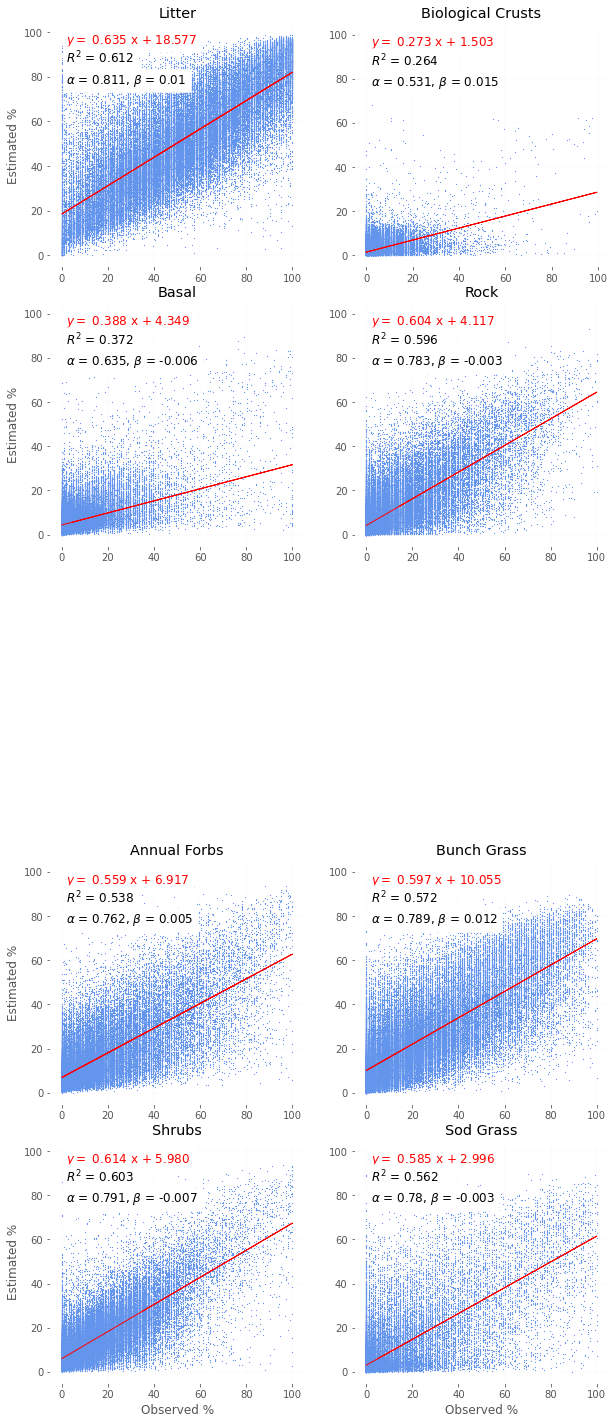

In [346]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='white'
np.set_printoptions(suppress=True)

observed_Litter = rsDataset.Litter.values
predict_Litter = rsDataset.Litter_pred.values
slope, intercept, r_value, p_value, std_err = linregress(observed_Litter, predict_Litter)
r_squared_Litter = r2_score(observed_Litter, predict_Litter)
alpha_Litter = np.std(predict_Litter)/np.std(observed_Litter)
beta_Litter = (np.mean(predict_Litter) - np.mean(observed_Litter))/np.std(observed_Litter)

observed_BiologicalCrusts = rsDataset.BiologicalCrusts.values
predict_BiologicalCrusts = rsDataset.BiologicalCrusts_pred.values
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(observed_BiologicalCrusts, predict_BiologicalCrusts)
r_squared_BiologicalCrusts = r2_score(observed_BiologicalCrusts, predict_BiologicalCrusts)
alpha_BiologicalCrusts = np.std(predict_BiologicalCrusts)/np.std(observed_BiologicalCrusts)
beta_BiologicalCrusts = (np.mean(predict_BiologicalCrusts) - np.mean(observed_BiologicalCrusts))/np.std(observed_BiologicalCrusts)


observed_Basal = rsDataset.Basal.values
predict_Basal = rsDataset.Basal_pred.values
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(observed_Basal, predict_Basal)
r_squared_Basal = r2_score(observed_Basal, predict_Basal)
alpha_Basal = np.std(predict_Basal)/np.std(observed_Basal)
beta_Basal = (np.mean(predict_Basal) - np.mean(observed_Basal))/np.std(observed_Basal)

observed_Rock = rsDataset.Rock.values
predict_Rock = rsDataset.Rock_pred.values
slope3, intercept3, r_value3, p_value3, std_err3 = linregress(observed_Rock, predict_Rock)
r_squared_Rock = r2_score(observed_Rock, predict_Rock)
alpha_Rock = np.std(predict_Rock)/np.std(observed_Rock)
beta_Rock = (np.mean(predict_Rock) - np.mean(observed_Rock))/np.std(observed_Rock)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = {'size'   : 14}

fig = plt.figure(figsize=(10,25))
gs = gridspec.GridSpec(5,2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(np.asarray(observed_Litter), slope*np.asarray(observed_Litter) + intercept, color='red', linewidth=1)
ax1.scatter(observed_Litter, predict_Litter, color='cornflowerblue', s=0.5, rasterized=True)
ax1.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope,3), np.round(intercept,3)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_Litter,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_Litter,3), np.round(beta_Litter,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.set_title('Litter')
ax1.set_ylabel('Estimated %')
ax1.grid(color='gainsboro', linestyle='-', linewidth=0.1)


ax2.plot(np.asarray(observed_BiologicalCrusts), slope1*np.asarray(observed_BiologicalCrusts) + intercept1, color='red', linewidth=1)
ax2.scatter(observed_BiologicalCrusts, predict_BiologicalCrusts, color='cornflowerblue', s=0.5, rasterized=True)
ax2.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope1,3), np.round(intercept1,3)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_BiologicalCrusts,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_BiologicalCrusts,3), np.round(beta_BiologicalCrusts,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.set_title('Biological Crusts')
ax2.grid(color='gainsboro', linestyle='-', linewidth=0.1)
ax2.set_ylim((-5,105))


ax3.plot(np.asarray(observed_Basal), slope1*np.asarray(observed_Basal) + intercept2, color='red', linewidth=1)
ax3.scatter(observed_Basal, predict_Basal, color='cornflowerblue', s=0.5, rasterized=True)
ax3.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope2,3), f"{intercept2:.3f}"), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_Basal,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_Basal,3), np.round(beta_Basal,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.set_title('Basal')
ax3.set_ylabel('Estimated %')
ax3.grid(color='gainsboro', linestyle='-', linewidth=0.1)
ax3.set_ylim((-5,105))



ax4.plot(np.asarray(observed_Rock), slope3*np.asarray(observed_Rock) + intercept3, color='red', linewidth=1)
ax4.scatter(observed_Rock, predict_Rock, color='cornflowerblue', s=0.5, rasterized=True)
ax4.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope3,3), f"{intercept3:.3f}"), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax4.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_Rock,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax4.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_Rock,3), np.round(beta_Rock,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax4.set_title('Rock')
ax4.grid(color='gainsboro', linestyle='-', linewidth=0.1)
ax4.set_ylim((-5,105))

####################################################################
observed_Forbs = rsDataset.Forbs.values
predict_Forbs = rsDataset.Forbs_pred.values
slope4, intercept4, r_value4, p_value4, std_err4 = linregress(observed_Forbs, predict_Forbs)
r_squared_Forbs = r2_score(observed_Forbs, predict_Forbs)
alpha_Forbs = np.std(predict_Forbs)/np.std(observed_Forbs)
beta_Forbs = (np.mean(predict_Forbs) - np.mean(observed_Forbs))/np.std(observed_Forbs)

observed_BunchGrass = rsDataset.BunchGrass.values
predict_BunchGrass = rsDataset.BunchGrass_pred.values
slope5, intercept5, r_value5, p_value5, std_err5 = linregress(observed_BunchGrass, predict_BunchGrass)
r_squared_BunchGrass = r2_score(observed_BunchGrass, predict_BunchGrass)
alpha_BunchGrass = np.std(predict_BunchGrass)/np.std(observed_BunchGrass)
beta_BunchGrass = (np.mean(predict_BunchGrass) - np.mean(observed_BunchGrass))/np.std(observed_BunchGrass)


observed_Shrubs = rsDataset.Shrubs.values
predict_Shrubs = rsDataset.Shrubs_pred.values
slope6, intercept6, r_value6, p_value6, std_err6 = linregress(observed_Shrubs, predict_Shrubs)
r_squared_Shrubs = r2_score(observed_Shrubs, predict_Shrubs)
alpha_Shrubs = np.std(predict_Shrubs)/np.std(observed_Shrubs)
beta_Shrubs = (np.mean(predict_Shrubs) - np.mean(observed_Shrubs))/np.std(observed_Shrubs)

observed_SodGrass = rsDataset.SodGrass.values
predict_SodGrass = rsDataset.SodGrass_pred.values
slope7, intercept7, r_value7, p_value7, std_err7 = linregress(observed_SodGrass, predict_SodGrass)
r_squared_SodGrass = r2_score(observed_SodGrass, predict_SodGrass)
alpha_SodGrass = np.std(predict_SodGrass)/np.std(observed_SodGrass)
beta_SodGrass = (np.mean(predict_SodGrass) - np.mean(observed_SodGrass))/np.std(observed_SodGrass)


ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3, 1])
ax7 = fig.add_subplot(gs[4, 0])
ax8 = fig.add_subplot(gs[4, 1])



ax5.plot(np.asarray(observed_Forbs), slope4*np.asarray(observed_Forbs) + intercept4, color='red', linewidth=1)
ax5.scatter(observed_Forbs, predict_Forbs, color='cornflowerblue', s=0.5, rasterized=True)
ax5.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope4,3), np.round(intercept4,3)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax5.set_ylim((-5,105))
ax5.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_Forbs,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax5.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_Forbs,3), np.round(beta_Forbs,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax5.set_title('Annual Forbs')
ax5.set_ylabel('Estimated %')
ax5.grid(color='gainsboro', linestyle='-', linewidth=0.1)


ax6.plot(np.asarray(observed_BunchGrass), slope5*np.asarray(observed_BunchGrass) + intercept5, color='red', linewidth=1)
ax6.scatter(observed_BunchGrass, predict_BunchGrass, color='cornflowerblue', s=0.5, rasterized=True)
ax6.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope5,3), np.round(intercept5,3)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax6.set_ylim((-5,105))
ax6.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_BunchGrass,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax6.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_BunchGrass,3), np.round(beta_BunchGrass,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax6.set_title('Bunch Grass')
ax6.grid(color='gainsboro', linestyle='-', linewidth=0.1)


ax7.plot(np.asarray(observed_Shrubs), slope6*np.asarray(observed_Shrubs) + intercept6, color='red', linewidth=1)
ax7.scatter(observed_Shrubs, predict_Shrubs, color='cornflowerblue', s=0.5, rasterized=True)
ax7.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope6,3), f"{intercept6:.3f}"), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax7.set_ylim((-5,105))
ax7.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_Shrubs,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax7.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_Shrubs,3), np.round(beta_Shrubs,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax7.set_title('Shrubs')
ax7.set_xlabel('Observed %')
ax7.set_ylabel('Estimated %')
ax7.grid(color='gainsboro', linestyle='-', linewidth=0.1)


ax8.plot(np.asarray(observed_SodGrass), slope7*np.asarray(observed_SodGrass) + intercept7, color='red', linewidth=1)
ax8.scatter(observed_SodGrass, predict_SodGrass, color='cornflowerblue', s=0.5, rasterized=True)
ax8.text(2, 95, r'$y = $ {} x $ + $ {}'.format(np.round(slope7,3), f"{intercept7:.3f}"), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax8.set_ylim((-5,105))
ax8.text(2, 86, r'$R^2$ = {}'.format(np.round(r_squared_SodGrass,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax8.text(2, 77, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_SodGrass,3), np.round(beta_SodGrass,3)), color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax8.set_title('Sod Grass')
ax8.set_xlabel('Observed %')
ax8.grid(color='gainsboro', linestyle='-', linewidth=0.1)



plt.subplots_adjust(hspace=0.15,
                    wspace=0.2)


#plt.savefig('/home/kia/Documents/RHEM/Manuscripts/RS/k_fold.svg',bbox_inches='tight', dpi=300, facecolor='white')

### 3- Get the RHEM outputs using the estimated covers

With the Foliar/Ground covers estimated for the data samples, we are able to get the RHEM outputs using the RHEM emulator.

First, we load the RHEM emulator in the cell below:

In [7]:
def weighted_binary_crossentropy(zero_weight=1.0, one_weight=1.0):

    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype='float64')
        y_pred = tf.cast(y_pred, dtype='float64')
        b_ce = K.binary_crossentropy(y_true, y_pred)
        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
emulator = tf.keras.models.load_model('Files/Trained_Emulator/emulator.h5', 
                                      custom_objects={ 'weighted_binary_crossentropy': weighted_binary_crossentropy()})

Then we load the data normalizers required by the RHEM emulator in the cell below:

In [8]:
with open('Files/Normalizers/minmaxt_x.pkl', 'rb') as file:
    minmaxt_x = pickle.load(file)    
with open('Files/Normalizers/minmaxt_y_runoff.pkl', 'rb') as file:
    minmaxt_y_runoff = pickle.load(file)
with open('Files/Normalizers/minmaxt_y_erosion.pkl', 'rb') as file:
    minmaxt_y_erosion = pickle.load(file)

We also need a set of functions that prepare a RHEM scenario out of a row of the dataset table:

In [9]:
cligenTab = pd.read_csv('Files/Parameter_Files/cligen.csv')
def get_cligen_pars(station_ID):
    
    if type(station_ID) != str:
        raise Exception('The stationID must be a string')

    if station_ID not in cligenTab['ID'].values.tolist():
        raise Exception('stationID is not among the available CLIGEN stations')

    cligenPar = cligenTab[cligenTab['ID'] == station_ID].iloc[0,:-1].values
    return cligenPar[0], cligenPar[1], cligenPar[2], cligenPar[3]


def slope_prop(slope, slope_shape):
    
    if not isinstance(slope, numbers.Number):
        raise Exception('The slope must be a number between 0 and 100 inclusive')
    if slope > 100 or slope < 0:
        raise Exception('The slope must be between 0 and 100 inclusive')
        
    if type(slope_shape) != str:
        raise Exception('The slope shape must be one of the following: uniform, convex, concave')
    
    slope_shape = slope_shape.lower()
    if slope_shape not in ['uniform', 'convex', 'concave', 'linear']:
        raise Exception('The slope shape must be one of the following: uniform(or linear), convex, concave')
        
    if slope_shape == 'uniform' or slope_shape == 'linear':
        SL1 = slope/100
        SL2 = slope/100

    elif slope_shape == 'convex':
        SL1 = 0.001
        SL2 = slope/100

    else:
        SL1 = slope/100
        SL2 = 0.001
    
    return SL1, SL2


soil = pd.read_csv('Files/Parameter_Files/Soil_Hydraulic_Properties.csv')
def soil_prop_from_texture(soilTexture):
    soilTexture = soilTexture.lower()
    if not soilTexture in soil.Soil_Texture_Class.values.tolist():
        raise Exception('The Selected soil texture is unknown')
    else:
        soilParameters = soil[soil['Soil_Texture_Class'] == soilTexture].values[0,1:].tolist()
        return soilParameters[0], soilParameters[1], soilParameters[2], soilParameters[3], soilParameters[4], soilParameters[5], soilParameters[6], soilParameters[7], soilParameters[8]

    
def check_the_ground_covers(Litter, BiologicalCrusts, Basal, Rock):
    
    coverList = [Litter, BiologicalCrusts, Basal, Rock]
        
    numCheck = [isinstance(i, numbers.Number) for i in coverList]
    if not all(numCheck):
        raise Exception('All covers must be numeric')
        
    if not all(np.array(coverList) >= 0) or not all(np.array(coverList) <= 100):
        raise Exception('All covers must be between 0 and 100 inclusive')
        
    if np.sum(np.array(coverList)) > 101:
        print(np.sum(np.array(coverList)))
        raise Exception('The covers must sum up to a value less than or equal to 100')

    return Litter, BiologicalCrusts, Basal, Rock, np.sum(np.array(coverList))


def check_the_foliar_covers(Forbs, BunchGrass, Shrubs, SodGrass):
    
    coverList = [Forbs, BunchGrass, Shrubs, SodGrass]
        
    numCheck = [isinstance(i, numbers.Number) for i in coverList]
    if not all(numCheck):
        raise Exception('All covers must be numeric')
        
    if not all(np.array(coverList) >= 0) or not all(np.array(coverList) <= 100):
        raise Exception('All covers must be between 0 and 100 inclusive')
        
    if np.sum(np.array(coverList)) > 101:
        print(np.sum(np.array(coverList)))
        raise Exception('The covers must sum up to a value less than or equal to 100')

    return Forbs, BunchGrass, Shrubs, SodGrass, np.sum(np.array(coverList))


def create_input(scenario):
    
    prcp, dur, tp, ip = get_cligen_pars(scenario['ID'])
    
    SL1, SL2 = slope_prop(scenario['slope'], scenario['slopeShape'])
    
    G, DIST, POR, SMAX, FRACT1, FRACT2, FRACT3, FRACT4, FRACT5 = soil_prop_from_texture(scenario['soil'])
    
    Litter, BiologicalCrusts, Basal, Rock, totalGround = check_the_ground_covers(scenario['Litter_pred'],
                                                                                 scenario['BiologicalCrusts_pred'],
                                                                                 scenario['Basal_pred'], 
                                                                                 scenario['Rock_pred'])
    
    Forbs, BunchGrass, Shrubs, SodGrass, totalFoliar = check_the_foliar_covers(scenario['Forbs_pred'], 
                                                                               scenario['BunchGrass_pred'], 
                                                                               scenario['Shrubs_pred'], 
                                                                               scenario['SodGrass_pred'])
    
    return np.expand_dims([prcp, dur, tp, ip, SL1, SL2, G, DIST, POR, SMAX, FRACT1, FRACT2, FRACT3, 
            FRACT4, FRACT5, Litter, BiologicalCrusts, Basal, Rock, totalGround, Forbs, 
            BunchGrass, Shrubs, SodGrass, totalFoliar], axis=0)


#### Finally, Run the cell below to get the RHEM outputs and save them in the dataset table:

In [11]:
def RHEM_Emulator_batch(table):
    
    batch_items = table.to_dict('records')
    
    for index, item in enumerate(batch_items):
        if index == 0:
            scenarios = create_input(item)
        else:
            scenarios = np.concatenate([scenarios, create_input(item)], axis=0)
    
    X = scenarios.copy()
    X[:,15:] = X[:,15:]/100
    X[:,[0,1,3,6]] = minmaxt_x.transform(X[:,[0,1,3,6]])
    
    predicted = emulator.predict(tf.convert_to_tensor(X))
    predicted = np.squeeze(np.array(predicted), axis=2).T

    predicted[:,2:3] = minmaxt_y_runoff.inverse_transform(predicted[:,2:3])
    predicted[:,3:4] = minmaxt_y_erosion.inverse_transform(predicted[:,3:4])
    predicted[:,4:] = minmaxt_y_erosion.inverse_transform(predicted[:,4:])

    predicted[:,2:3] = np.exp(predicted[:,2:3])
    predicted[:,3:] = np.exp(predicted[:,3:])

    predicted[:, 2] = predicted[:, 2] * predicted[:, 0]
    predicted[:, 3] = predicted[:, 3] * predicted[:, 1]
    predicted[:, 4] = predicted[:, 4] * predicted[:, 1]
    
    table.at[:, 'Avg_Runoff(mm/year)_pred'] = predicted[:,2:3]
    table.at[:, 'Avg_SoilLoss(Mg/ha/year)_pred'] = predicted[:,3:4]
    table.at[:, 'Avg_SedYield(Mg/ha/year)_pred'] = predicted[:,4:]
    
    return table

rsDataset_with_RHEM = RHEM_Emulator_batch(rsDataset)
rsDataset_with_RHEM

,PrimaryKey,Litter,BiologicalCrusts,Basal,Rock,totalGround,Forbs,BunchGrass,Shrubs,SodGrass,...,SodGrass_pred,totalFoliar_pred,Litter_pred,BiologicalCrusts_pred,Basal_pred,Rock_pred,totalGround_pred,Avg_Runoff(mm/year)_pred,Avg_SoilLoss(Mg/ha/year)_pred,Avg_SedYield(Mg/ha/year)_pred
0,201406013040401B3,97.029703,0.000000,0.000000,0.000000,97.029703,83.168317,12.871287,0.000000,0.000000,...,1.588327,84.021700,80.708600,0.024160,3.012240,0.333414,84.078415,34.021431,0.542771,0.536898
1,20143217206311B2,26.732673,0.000000,6.930693,64.356436,98.019802,0.000000,6.930693,28.712871,0.990099,...,0.311278,22.315560,18.573076,0.368245,0.703594,54.583115,74.228035,7.725078,0.345240,0.342205
2,201420033050102R3,44.554455,0.000000,0.000000,0.000000,44.554455,71.287129,10.891089,2.970297,0.990099,...,22.557875,89.839480,51.796635,1.041502,5.292141,0.915788,59.046062,84.097656,0.282620,0.282246
3,17083009552483352017-09-01,62.000000,0.000000,2.666667,0.000000,64.666667,30.000000,4.666667,39.333333,0.000000,...,1.935397,70.196270,65.014470,1.960695,2.080969,5.396801,74.452934,6.824438,0.096443,0.095289
4,201730017061001G1,34.653465,0.000000,3.960396,18.811881,57.425743,8.910891,6.930693,4.950495,12.871287,...,13.984047,70.355840,35.977490,3.249513,17.072977,3.733932,60.033913,24.941769,0.345155,0.343305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66638,20175629104602B2,67.326733,0.990099,13.861386,0.000000,82.178218,15.841584,28.712871,44.554455,0.000000,...,1.974510,43.562580,29.360426,4.079928,5.274138,17.306042,56.020530,16.307606,0.093739,0.011040
66639,18050207084836382018-09-01,54.666667,0.000000,1.333333,25.333333,81.333333,2.000000,6.000000,2.000000,41.333333,...,2.995095,44.933445,44.834690,1.519971,7.023753,17.823467,71.201880,3.878521,0.108234,0.008513
66640,201348137030301R2,40.594059,0.000000,0.990099,49.504950,91.089109,0.000000,2.970297,31.683168,0.000000,...,1.526399,48.655487,34.279900,0.143390,3.367106,51.035700,88.826096,181.507462,5.725914,5.651587
66641,200508099060301G2,70.297030,0.000000,5.940594,0.000000,76.237624,8.910891,52.475248,8.910891,0.000000,...,5.205893,91.567200,14.693642,0.030373,10.811639,0.152368,25.688019,45.471119,0.022411,0.022261
